In [41]:
# using packages
using Gadfly
using CSV
using DataFrames
using Hose
using Compose

In [50]:
# read data

rawdatas::Vector{Tuple{String,DataFrame}} = @hose readdir() |>
                                                  filter(endswith(".csv"), _) |>
                                                  map(x -> (x, CSV.read(x, DataFrame)), _)

for (name, frame::DataFrame) in rawdatas
    frame.locktype .= @hose name |> replace(_, ".csv" => "")
end

lockdata = @hose rawdatas |>
                 map(x -> x[2], _) |>
                 reduce(vcat, _)


lockdata.cpu = @hose lockdata.locktype |>
                    map(x->parse.(Int64, [ match.match for match in eachmatch(r"[[:digit:]]+", x)])[1], _)

lockdata.thread = @hose lockdata.locktype |>
                    map(x->parse.(Int64, [ match.match for match in eachmatch(r"[[:digit:]]+", x)])[2], _)

lockdata.locktype = @hose lockdata.locktype |>
                          filter.(x -> !isdigit(x) && x != '_', _)



378-element Vector{String}:
 "CC Synch"
 "CC Synch"
 "CC Synch"
 "CC Synch"
 "CC Synch"
 "CC Synch"
 "CC Synch"
 "CC Synch"
 "CC Synch"
 "CC Synch"
 ⋮
 "Remote Core Locking"
 "Remote Core Locking"
 "Remote Core Locking"
 "Remote Core Locking"
 "Remote Core Locking"
 "Remote Core Locking"
 "Remote Core Locking"
 "Remote Core Locking"
 "Remote Core Locking"

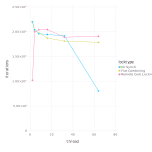

In [53]:
## Plot Overall Iteration group by cpu

iteration_data = @hose lockdata |>
                     groupby([:locktype, :thread]) |>
                     combine(:loop => sum => :iterations)


@hose iteration_data |>
      plot(x=:thread, y=:iterations, color=:locktype, Geom.point, Geom.line) |>
      draw(SVG(6inch, 6inch), _)

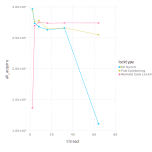

In [54]:
## Plot Lock Acquire Time group by cpu

acquire_data = @hose lockdata |>
                     groupby([:locktype, :thread]) |>
                     combine(:lock_acquires => sum => :all_acquire)

@hose acquire_data |>
    plot(x=:thread, y=:all_acquire, color=:locktype, Geom.point, Geom.line) |>
    draw(SVG(6inch, 6inch), _)

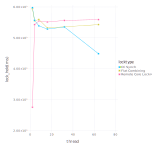

In [55]:
## Plot overall lock acquire time group by cpu

overall_hold_data = @hose lockdata |>
                     groupby([:locktype, :thread]) |>
                     combine("lock_hold(ms)" => sum => "lock_hold(ms)")

@hose overall_hold_data |>
    plot(x=:thread, y=:"lock_hold(ms)", color=:locktype, Geom.point, Geom.line) |>
    draw(SVG(6inch, 6inch), _)


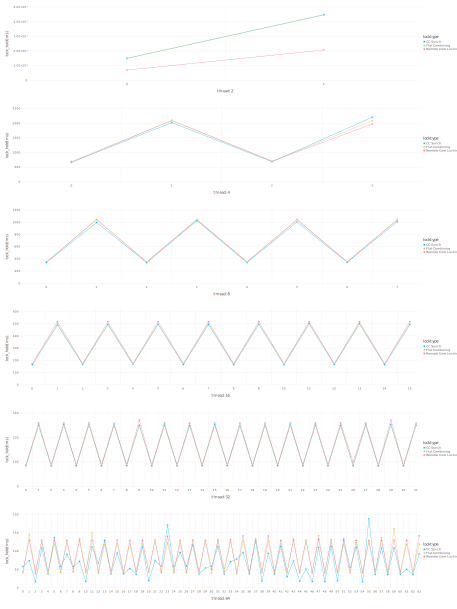

In [57]:
## Plot Individual Lock Acquire Time with x asix being the id, and stack the plot based on cpu

individual_hold_data = @hose lockdata |>
                             groupby([:thread])

@hose keys(individual_hold_data) |>
      map(x -> (x, individual_hold_data[x]), _) |>
      map(pair -> plot(pair[2],
              x=:id,
              color=:locktype,
              layer(y=:"lock_hold(ms)", Geom.point, Geom.line),
              Scale.x_discrete(),
              Guide.xlabel("thread: $(pair[1].thread)")), _) |>
      vstack |>
      draw(SVG(18inch, 24inch), _)

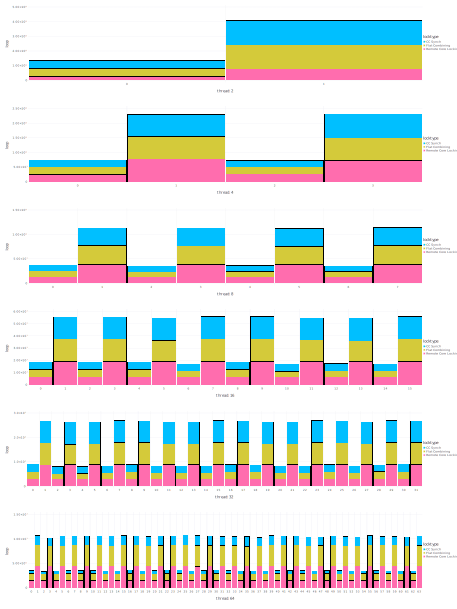

In [60]:
## Plot Individual Loop with x asix being the id, and stack the plot based on cpu
using Hose, Gadfly, DataFrames, CSV, Compose


@hose keys(individual_hold_data) |>
      map(x -> (x, individual_hold_data[x]), _) |>
      map(pair -> plot(pair[2],
                      x=:id,
                      y=:"loop",
                      color=:locktype,
                      Geom.bar(),
                      Theme(bar_highlight=colorant"black", bar_spacing=1mm),
                      Scale.x_discrete(),
                      Guide.xlabel("thread: $(pair[1].thread)")), _) |>
      vstack |>
      draw(SVG(18inch, 24inch), _)

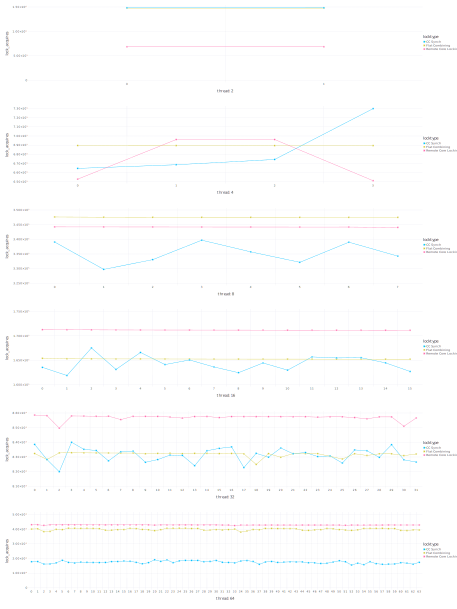

In [62]:
## Plot Individual lock_acquires with x asix being the id, and stack the plot based on cpu


@hose keys(individual_hold_data) |>
      map(x -> (x, individual_hold_data[x]), _) |>
      map(pair -> plot(pair[2],
              x=:id,
              color=:locktype,
              layer(y=:lock_acquires, Geom.point, Geom.line),
              Scale.x_discrete(),
              Guide.xlabel("thread: $(pair[1].thread)")), _) |>
      vstack |>
      draw(SVG(18inch, 24inch), _)